#### This notebook demonstrates the use of an odds-equalizing post-processing algorithm for bias mitigiation.


In [11]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(0, '/home/jl0274/AIF360')
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult

from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from common_utils import compute_metrics

### Fairness metrics for original dataset

In [3]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

In [4]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    # dataset_orig = AdultDataset()
    dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = 12345679 

standard dataset: is na? False


#### Divide dataset into train, validation, and test partitions (70-30)

In [5]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Training data characteristics

In [6]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_population', 'tract_minority_population_percent', 'property_value', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for the original datasets (without any classifiers)

In [7]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053437


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.056635


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.047185


## Gender Present

### Train classifier (logistic regression on original training data)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# xgboost classifier and predictions for training data
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()

svc = SGDClassifier(loss='hinge', penalty=None, alpha=0.0001, verbose=True)
svc = CalibratedClassifierCV(svc, method="sigmoid", cv=5)

with tqdm(total=1, desc="Training SVC") as pbar:
    svc.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    pbar.update()

fav_idx = np.where(svc.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = svc.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = dataset_orig_valid.features
y_valid_pred_prob = svc.predict_proba(X_valid)[:,fav_idx]

X_test = dataset_orig_test.features
y_test_pred_prob = svc.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

Training SVC:   0%|          | 0/1 [00:00<?, ?it/s]

-- Epoch 1
Norm: 52.14, NNZs: 21, Bias: 14.871788, T: 661636, Avg. loss: 0.131501
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 52.28, NNZs: 21, Bias: 14.893757, T: 1323272, Avg. loss: 0.111559
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 52.41, NNZs: 21, Bias: 14.913230, T: 1984908, Avg. loss: 0.109908
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 52.52, NNZs: 21, Bias: 14.922365, T: 2646544, Avg. loss: 0.109033
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 52.62, NNZs: 21, Bias: 14.929329, T: 3308180, Avg. loss: 0.108463
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 52.71, NNZs: 21, Bias: 14.939909, T: 3969816, Avg. loss: 0.108076
Total training time: 0.46 seconds.
-- Epoch 7
Norm: 52.79, NNZs: 21, Bias: 14.941582, T: 4631452, Avg. loss: 0.107793
Total training time: 0.53 seconds.
-- Epoch 8
Norm: 52.87, NNZs: 21, Bias: 14.937533, T: 5293088, Avg. loss: 0.107588
Total training time: 0.61 seconds.
Convergence after 8 epochs took 0.61 seconds
-- Epoch 1
N

Training SVC: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


### Fairness and accuracy metrics with theshold = 0.5

In [13]:
metric_orig_test_pred = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_orig_test_pred.mean_difference()}")

DIM in outcome: 0.04718453294274916


In [14]:
compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9696
Statistical parity difference = 0.0449
Disparate impact = 1.0652
Average odds difference = 0.0025
Equal opportunity difference = -0.0014
Theil index = 0.0401


OrderedDict([('Balanced accuracy', 0.9696374140681668),
             ('Statistical parity difference', 0.044933782975827063),
             ('Disparate impact', 1.0651545665237787),
             ('Average odds difference', 0.0024944944331436385),
             ('Equal opportunity difference', -0.0013875420420339513),
             ('Theil index', 0.04010920957964867)])

In [15]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc
    
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, 0.5)

F1 Score: 0.9723
ROC AUC Score: 0.9895


In [16]:
# bias summary metrics
def bias_summary_metrics(gender_col, target):
    # test whether loan approval significantly depends on gender
    gender_col = pd.Series(gender_col)  # Convert gender to categorical
    target = pd.Series(target.ravel())

    # Create a contingency table
    contingency_table = pd.crosstab(gender_col, target)
    
    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("There is a significant association between gender and loan approval.")
    else:
        print("There is no significant association between gender and loan approval.")

    # test whether there's a significant difference in loan approval proportions across men vs women

    # Count of approvals for men and women
    men_approved = sum((gender_col == 0) & (target == 1))
    women_approved = sum((gender_col == 1) & (target == 1))
    
    # Total number of applicants in each group
    men_total = sum(gender_col == 0)
    women_total = sum(gender_col == 1)
    
    # Run the Z-test
    count = [men_approved, women_approved]
    nobs = [men_total, women_total]
    stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value:10e}")
    
    if p_value < 0.05:
        print("There is a significant difference in loan approval rates between men and women.")
    else:
        print("There is no significant difference in loan approval rates between men and women.")

    men_approved_prop = men_approved/men_total
    women_approved_prop = women_approved/women_total
    print(f'male approval rate: {men_approved_prop}')
    print(f'female approval rate: {women_approved_prop}')
    

In [17]:
bias_summary_metrics(X_test[:, -1], dataset_orig_test_pred.labels)

Chi-Square Statistic: 401.5276328364944
P-value: 2.5608830965193816e-89
There is a significant association between gender and loan approval.
Z-statistic: 20.043701747125212
P-value: 2.290805e-89
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7345828033469183
female approval rate: 0.6896490203710912


#### Results before post-processing

In [18]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
0.0326606012913877
Difference in GFNR between unprivileged and privileged groups
0.0017285796500752584


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
0.03248293688873506
Difference in GFNR between unprivileged and privileged groups
0.0012345678613208608


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
0.03314516294374817
Difference in GFNR between unprivileged and privileged groups
0.0004921722189621461


### Perform odds equalizing post processing on scores

In [19]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

### Transform validation and test data using the post processing algorithm

In [20]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

#### Results after post-processing

In [21]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
0.029949680170475237
Difference in GFNR between unprivileged and privileged groups
-0.00015941169086849255


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
0.02940416476830289
Difference in GFNR between unprivileged and privileged groups
-0.0006606898178022


### Fairness and Accuracy Metrics for post-processed data

In [22]:
metric_transf_test_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_transf_test_pred.mean_difference()}")

DIM in outcome: 0.0430685954839366


In [23]:
compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9685
Statistical parity difference = 0.0431
Disparate impact = 1.0623
Average odds difference = -0.0007
Equal opportunity difference = -0.0017
Theil index = 0.0403


OrderedDict([('Balanced accuracy', 0.9684965807178906),
             ('Statistical parity difference', 0.0430685954839366),
             ('Disparate impact', 1.062281577145079),
             ('Average odds difference', -0.0006678769154869566),
             ('Equal opportunity difference', -0.0016563110798407665),
             ('Theil index', 0.04026917891666602)])

In [24]:
# Testing: Check if the rates for validation data has gone down
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

In [25]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


In [26]:
classified_metric_transf_test.precision

<bound method ClassificationMetric.precision of <aif360.metrics.classification_metric.ClassificationMetric object at 0x7efb79ab4860>>

In [27]:
# accuracy metrics
f1 = (2 * classified_metric_transf_test.precision() * classified_metric_transf_test.recall()) / (classified_metric_transf_test.precision() + classified_metric_transf_test.recall())
auc = roc_auc_score(dataset_orig_test.labels, dataset_transf_test_pred_thresh.scores)
print(f"f1 score: {f1}")
print(f"auc score: {auc}")

f1 score: 0.9634797294680002
auc score: 0.9894181663442172


In [28]:
bias_summary_metrics(X_test[:, -1], dataset_transf_test_pred.labels)

Chi-Square Statistic: 369.39630353497074
P-value: 2.533015363587171e-82
There is a significant association between gender and loan approval.
Z-statistic: 19.225236543739925
P-value: 2.275989e-82
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7345828033469183
female approval rate: 0.6915142078629817


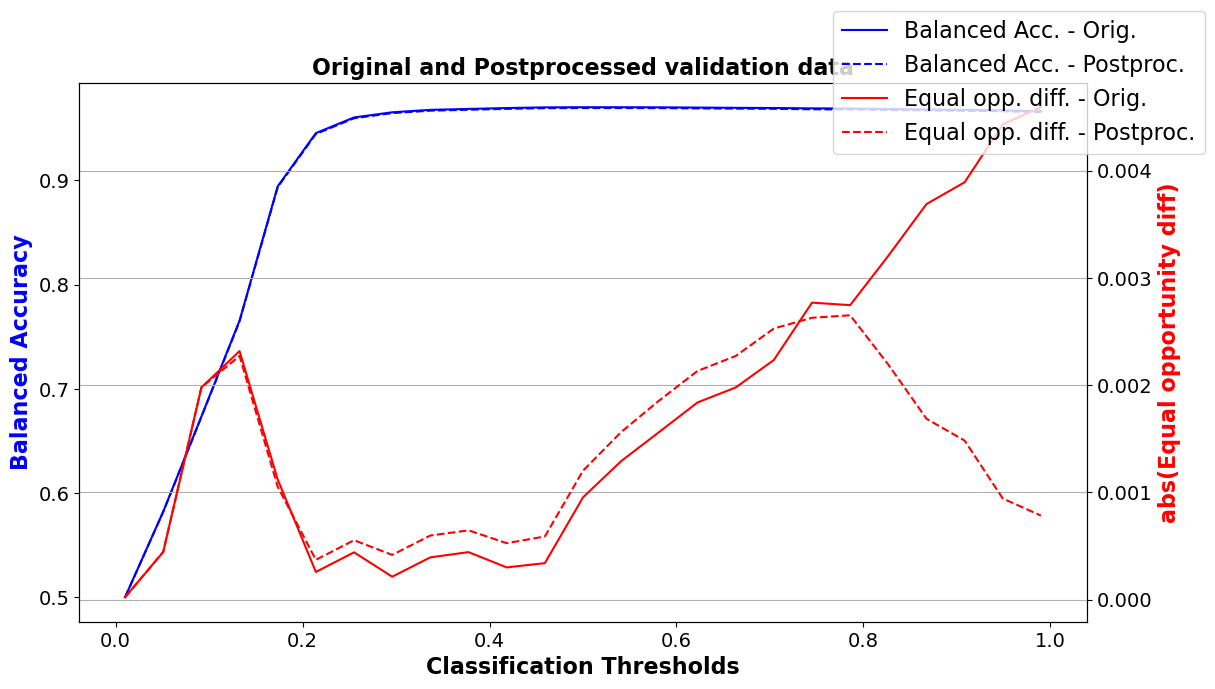

In [29]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

plt.show()

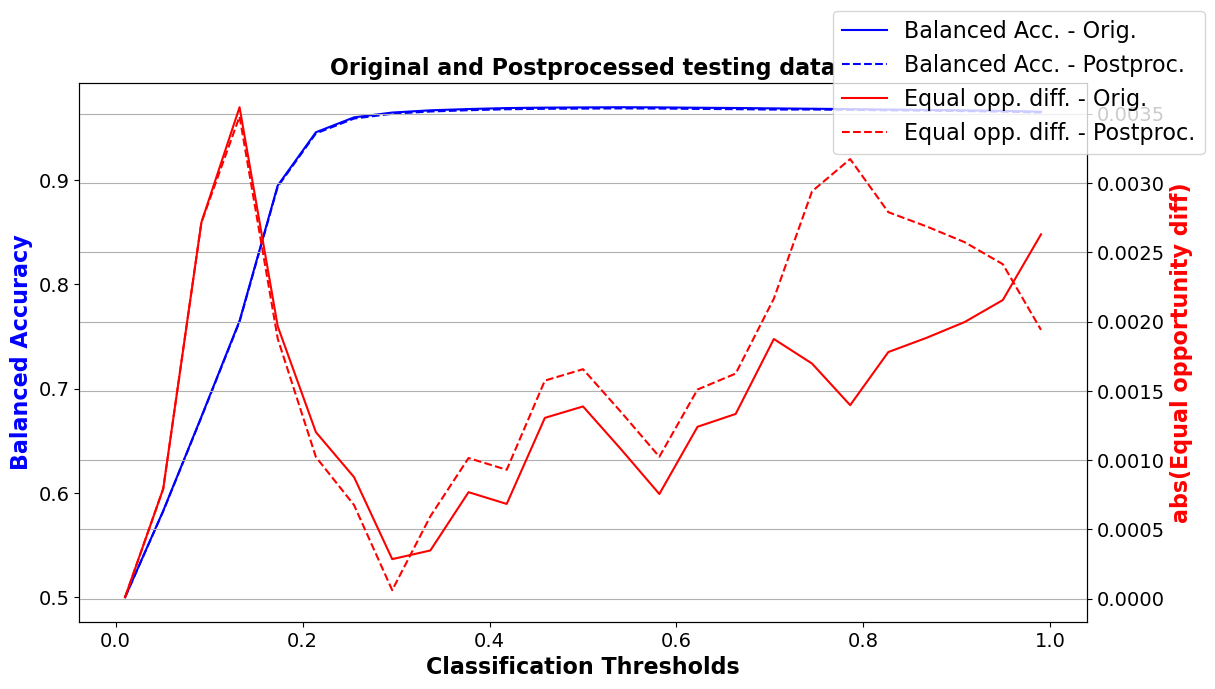

In [30]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

plt.savefig("eqodds-svc-eqopp-gen")

plt.show()

In [31]:
classified_metric_orig_test

## Gender Not Present

### Train classifier (logistic regression on original training data)

In [32]:
X_test = dataset_orig_test.features

In [33]:
gender_col = X_test[:, -1]

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
X_train = dataset_orig_train.features[:, :-1]
y_train = dataset_orig_train.labels.ravel()


svc = SGDClassifier(loss='hinge', penalty=None, alpha=0.0001, verbose=True)
svc = CalibratedClassifierCV(svc, method="sigmoid", cv=5)

with tqdm(total=1, desc="Training SVC") as pbar:
    svc.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    pbar.update()

fav_idx = np.where(svc.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = svc.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = dataset_orig_valid.features[:, :-1]
y_valid_pred_prob = svc.predict_proba(X_valid)[:,fav_idx]

X_test = dataset_orig_test.features[:, :-1]
y_test_pred_prob = svc.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

Training SVC:   0%|          | 0/1 [00:00<?, ?it/s]

-- Epoch 1
Norm: 49.25, NNZs: 20, Bias: 14.707906, T: 661636, Avg. loss: 0.128311
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 49.48, NNZs: 20, Bias: 14.737388, T: 1323272, Avg. loss: 0.110766
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 49.65, NNZs: 20, Bias: 14.774438, T: 1984908, Avg. loss: 0.109235
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 49.80, NNZs: 20, Bias: 14.780517, T: 2646544, Avg. loss: 0.108481
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 49.92, NNZs: 20, Bias: 14.779352, T: 3308180, Avg. loss: 0.108029
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 50.03, NNZs: 20, Bias: 14.786749, T: 3969816, Avg. loss: 0.107737
Total training time: 0.45 seconds.
-- Epoch 7
Norm: 50.13, NNZs: 20, Bias: 14.779408, T: 4631452, Avg. loss: 0.107544
Total training time: 0.53 seconds.
-- Epoch 8
Norm: 50.21, NNZs: 20, Bias: 14.781626, T: 5293088, Avg. loss: 0.107410
Total training time: 0.60 seconds.
Convergence after 8 epochs took 0.60 seconds
-- Epoch 1
N

Training SVC: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


### Fairness and accuracy metrics with theshold = 0.5

In [35]:
metric_orig_test_pred = BinaryLabelDatasetMetric(dataset_orig_test_pred, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_orig_test_pred.mean_difference()}")

DIM in outcome: 0.04246410463534833


In [36]:
compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9698
Statistical parity difference = 0.0425
Disparate impact = 1.0614
Average odds difference = -0.0001
Equal opportunity difference = -0.0038
Theil index = 0.0396


OrderedDict([('Balanced accuracy', 0.9698001907069072),
             ('Statistical parity difference', 0.04246410463534833),
             ('Disparate impact', 1.061371436098475),
             ('Average odds difference', -6.559258671893185e-05),
             ('Equal opportunity difference', -0.0038065794623469706),
             ('Theil index', 0.03956820762414126)])

In [37]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc

In [38]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, 0.5)

F1 Score: 0.9726
ROC AUC Score: 0.9896


In [39]:
bias_summary_metrics(gender_col, dataset_orig_test_pred.labels)

Chi-Square Statistic: 359.1055908519172
P-value: 4.408995363344552e-80
There is a significant association between gender and loan approval.
Z-statistic: 18.95563285145841
P-value: 3.967525e-80
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7343837880400453
female approval rate: 0.691919683404697


#### Results before post-processing

In [40]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
0.016908831750459152
Difference in GFNR between unprivileged and privileged groups
0.003689702526651996


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
0.01691542440721476
Difference in GFNR between unprivileged and privileged groups
0.00328401581242789


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
0.01748690278229824
Difference in GFNR between unprivileged and privileged groups
0.002575597185916635


### Perform odds equalizing post processing on scores

In [41]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

### Transform validation and test data using the post processing algorithm

In [42]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

#### Results after post-processing

In [43]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
0.009189653661225844
Difference in GFNR between unprivileged and privileged groups
-0.00013684284781216582


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
0.008924359575779112
Difference in GFNR between unprivileged and privileged groups
-0.0006090074617036423


### Fairness and Accuracy Metrics for post-processed data

In [44]:
metric_transf_test_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_transf_test_pred.mean_difference()}")

DIM in outcome: 0.03803631171981703


In [45]:
compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9672
Statistical parity difference = 0.0380
Disparate impact = 1.0546
Average odds difference = -0.0075
Equal opportunity difference = -0.0045
Theil index = 0.0399


OrderedDict([('Balanced accuracy', 0.9671607693746764),
             ('Statistical parity difference', 0.03803631171981703),
             ('Disparate impact', 1.0546226029579597),
             ('Average odds difference', -0.007490653306271548),
             ('Equal opportunity difference', -0.004545694316315796),
             ('Theil index', 0.03990985075953097)])

In [46]:
# Testing: Check if the rates for validation data has gone down
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

In [47]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


In [48]:
# accuracy metrics
f1 = (2 * classified_metric_transf_test.precision() * classified_metric_transf_test.recall()) / (classified_metric_transf_test.precision() + classified_metric_transf_test.recall())
auc = roc_auc_score(dataset_orig_test.labels, dataset_transf_test_pred_thresh.scores)
print(f"f1 score: {f1}")
print(f"auc score: {auc}")

f1 score: 0.9622255144543643
auc score: 0.9893855656727498


In [49]:
bias_summary_metrics(gender_col, dataset_transf_test_pred.labels)

Chi-Square Statistic: 289.07414893724916
P-value: 7.91210376600951e-65
There is a significant association between gender and loan approval.
Z-statistic: 17.007741373683153
P-value: 7.195890e-65
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7343837880400453
female approval rate: 0.6963474763202283


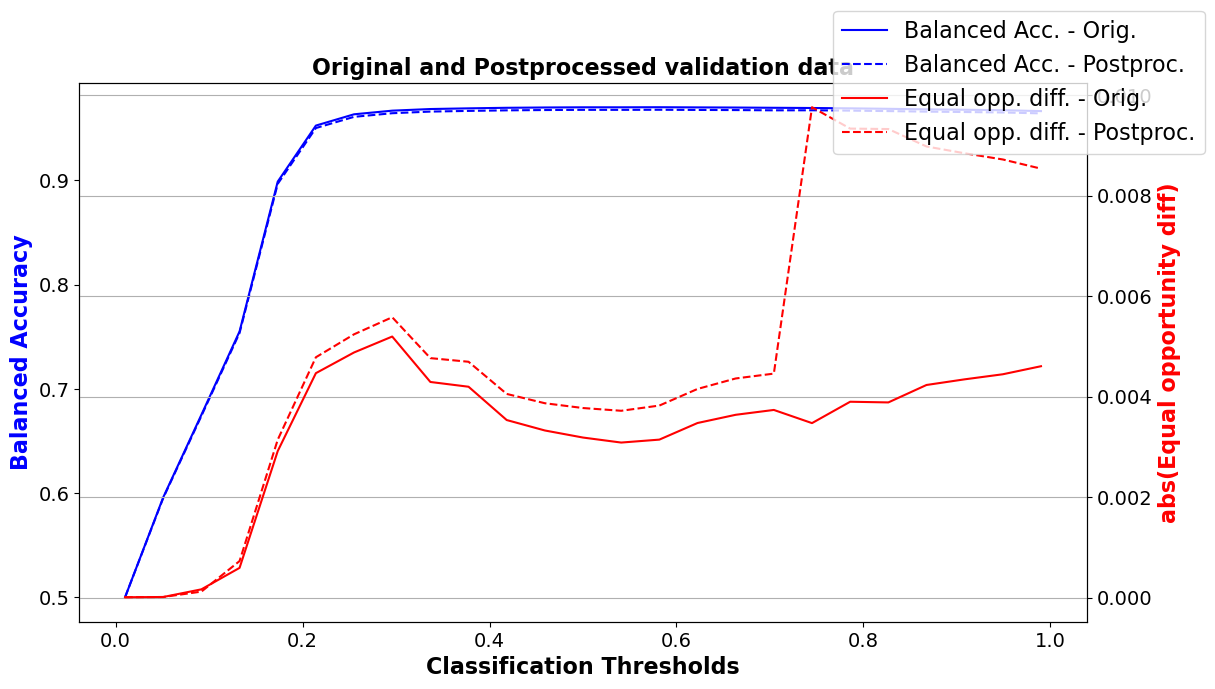

In [50]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

plt.show()

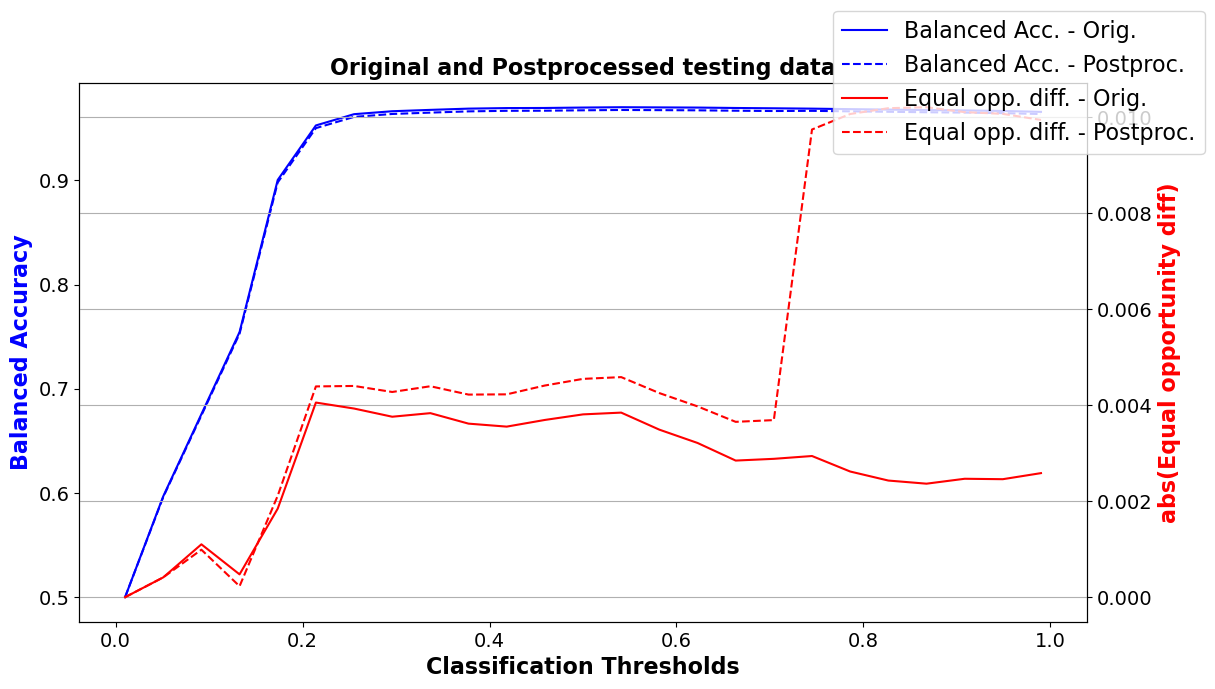

In [51]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

plt.savefig("eqodds-svc-eqopp-nogen")

plt.show()

In [52]:
classified_metric_orig_test